# Modelling DNN

# Module loading

In [1]:
import datetime, time, os

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import RootMeanSquaredError
    
print('Using TensorFlow version: %s' % tf.__version__)

RSEED = 42

Using TensorFlow version: 2.8.0


In [2]:
#!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

## Data loading

In [3]:
# Load data
df = pd.read_csv("../flight-delay/data/flight_data.csv")
X = df.copy()
y = X.pop("target")
df.head()

df_sub = pd.read_csv("../flight-delay/data/flight_submission.csv", index_col=0)
submission = pd.read_csv("../flight-delay/data/ID.csv", index_col=0)
X_sub = df_sub

Data Preprocessing

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

categories_country_ARR = [np.asarray(df.groupby("country_ARR").mean().sort_values(by="target").index)]
categories_country_DEP = [np.asarray(df.groupby("country_DEP").mean().sort_values(by="target").index)]
categories_DEPSTN = [np.asarray(df.groupby("DEPSTN").mean().sort_values(by="target").index)]
categories_ARRSTN = [np.asarray(df.groupby("ARRSTN").mean().sort_values(by="target").index)]
categories_FLTID = [np.asarray(df.groupby("FLTID").mean().sort_values(by="target").index)]
categories_AC = [np.asarray(df.groupby("AC").mean().sort_values(by="target").index)]

# Preprocessor pipelines
num_cols = ['distance', 'domestic', 'dep_hour', 'dep_weekday',
            'duration_min', "dep_day", "arr_hour"]
cat_cols = ["STATUS", "operator"]
# Preprocessor for numerical features
num_pipeline = Pipeline([
    #('num_scaler', StandardScaler()),
    ('num_scaler', MinMaxScaler())
])
# Preprocessor for categorical features 
cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Put together preprocessor pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('cat_AC', OrdinalEncoder(categories=categories_AC, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_AC[0])+1)), ["AC"]),
    ('cat_FLTID', OrdinalEncoder(categories=categories_FLTID, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_FLTID[0])+1)), ["FLTID"]),
    ('cat_ARRSTN', OrdinalEncoder(categories=categories_ARRSTN, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_ARRSTN[0])+1)), ["ARRSTN"]),
    ('cat_DEPSTN', OrdinalEncoder(categories=categories_DEPSTN, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_DEPSTN[0])+1)), ["DEPSTN"]),
    ('cat_country_ARR', OrdinalEncoder(categories=categories_country_ARR, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_country_ARR[0])+1)), ["country_ARR"]),
    ('cat_country_DEP', OrdinalEncoder(categories=categories_country_DEP, handle_unknown="use_encoded_value", 
                                unknown_value=(len(categories_country_DEP[0])+1)), ["country_DEP"])
])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, test_size=0.2)
X_sub = df_sub

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_sub = preprocessor.transform(X_sub)

print(X_train.shape, X_test.shape)

(86266, 37) (21567, 37)


## Training

### Build, compile and fit the model

In [6]:
# Clear recent logs
!rm -rf my_logs/
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")
# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)
# Store directory path for current run
run_logdir = get_run_logdir()
# Define function for creating callbacks
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    #tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1),
  ]

In [7]:
def model_compile_and_fit(model, name, optimizer=None, max_epochs=30):
    BATCH_SIZE = 500
    LEARNING_RATE = 0.001    # Get optimizer
    if optimizer == None:
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            LEARNING_RATE,
            decay_steps=len(X_train) // BATCH_SIZE,
            decay_rate=1,
            staircase=False)
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE , name='Adam')
    # model.compile
        with tf.device('/cpu:0'):
            model.compile(optimizer=optimizer,
            loss='mse',
            metrics=[RootMeanSquaredError()])
        print(model.summary())
    # model.fit
        history[name] = model.fit(X_train,
                                    y_train,
                                    validation_split=0.2,
                                    verbose=1,
                                    #steps_per_epoch=len(X_train) // BATCH_SIZE,
                                    batch_size=BATCH_SIZE,
                                    epochs=max_epochs,
                                    callbacks=get_callbacks(name),
                                    )
    return history

### Train the model

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 37)                1406      
                                                                 
 dense_1 (Dense)             (None, 32)                1216      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                              

2022-02-24 16:18:48.054996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 16:18:48.055160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-24 16:18:48.166150: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/139 [..............................] - ETA: 53s - loss: 22501.2695 - root_mean_squared_error: 150.0041

2022-02-24 16:18:48.387106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


138/139 [============================>.] - ETA: 0s - loss: 13073.4365 - root_mean_squared_error: 114.3390

2022-02-24 16:18:49.968010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch: 0, loss:13072.3262,  root_mean_squared_error:114.3341,  val_loss:12879.1758,  val_root_mean_squared_error:113.4862,  
139/139 [==============================] - 2s 12ms/step - loss: 13072.3262 - root_mean_squared_error: 114.3341 - val_loss: 12879.1758 - val_root_mean_squared_error: 113.4862
Epoch 2/50
139/139 [==============================] - 1s 10ms/step - loss: 12302.4932 - root_mean_squared_error: 110.9161 - val_loss: 12955.5459 - val_root_mean_squared_error: 113.8218
Epoch 3/50
139/139 [==============================] - 1s 10ms/step - loss: 12266.5654 - root_mean_squared_error: 110.7537 - val_loss: 12811.2383 - val_root_mean_squared_error: 113.1858
Epoch 4/50
139/139 [==============================] - 1s 10ms/step - loss: 12221.8740 - root_mean_squared_error: 110.5516 - val_loss: 12736.5537 - val_root_mean_squared_error: 112.8552
Epoch 5/50
139/139 [==============================] - 1s 9ms/step - loss: 12205.5215 - root_mean_squared_error: 110.4774 - val_loss: 12757.2090 -

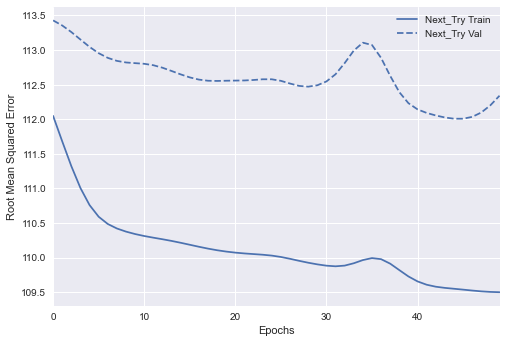

In [8]:
DROPOUT_RATE = 0.0
REGULARIZATION = 0.01

with tf.device('/cpu:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(37,kernel_initializer = 'uniform', activation='relu',input_dim = X_train.shape[1], kernel_regularizer=regularizers.l2(REGULARIZATION)),
        tf.keras.layers.Dense(32,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(REGULARIZATION)),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(32,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(REGULARIZATION)),
        tf.keras.layers.Dropout(DROPOUT_RATE),
        tf.keras.layers.Dense(1,kernel_initializer = 'uniform')
    ])

# compile and fit model
history = {}
history = model_compile_and_fit(model, 'next_try', max_epochs=50)
# plot history
history_plotter = tfdocs.plots.HistoryPlotter(metric = 'root_mean_squared_error', smoothing_std=10)
history_plotter.plot(history)

2022-02-24 16:19:51.207625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(-700.0, 300.0)

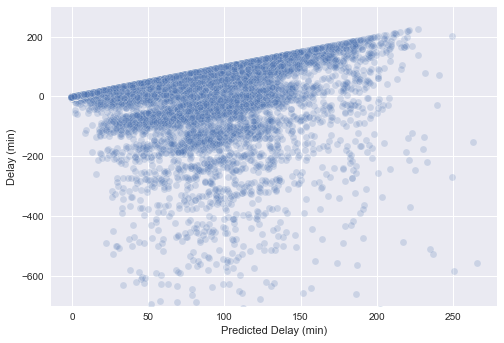

In [9]:
#import seaborn as sns

y_pred = model.predict(X_test).flatten()
residuals = y_pred - np.asarray(y_test)
sns.scatterplot(y_pred, residuals, alpha=0.2)
plt.xlabel("Predicted Delay (min)")
plt.ylabel("Delay (min)")
#plt.xlim(-5,250)
plt.ylim(-700,300)

In [10]:
loss, rmse = model.evaluate(X_test, y_test)
print(rmse)

674/674 [==============================] - 3s 5ms/step - loss: 14610.0469 - root_mean_squared_error: 120.8447
120.84465026855469


In [11]:
sub_target = model.predict(X_sub)

submission["target"] = sub_target
submission.to_csv("data/submission.csv", index=False)

max(sub_target)

array([359.2384], dtype=float32)